<a href="https://colab.research.google.com/github/KarryHarsh/git-set-go/blob/master/defaultersLoanV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [461]:
#!pip install trail

## Importing libabries

In [428]:
# Data analysis library
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
%matplotlib inline
# Machine Learning library
import sklearn
from sklearn.metrics import roc_curve, auc, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric
from sklearn.metrics import f1_score
# Hyperparameter tunning library
import optuna

# Plotting library
import matplotlib.pyplot as plt
# Prevent figures from displaying by turning interactive mode off using the function
plt.ioff()
import warnings
warnings.filterwarnings("ignore")

In [429]:
print(f'Numpy version is {np.__version__}')
print(f'Pandas version is {pd.__version__}')
print(f'sklearn version is {sklearn.__version__}')
print(f'joblib version is {joblib.__version__}')
print(f'optuna version is {optuna.__version__}')

Numpy version is 1.19.5
Pandas version is 1.1.5
sklearn version is 0.22.2.post1
joblib version is 1.0.1
optuna version is 2.6.0


## Introduction to the Data

In [430]:
## Files
data_file = '/content/train_indessa.csv'

# Load train loan dataset 
try:
    data = pd.read_csv(data_file)
    print("The dataset has {} samples with {} features.".format(*data.shape))
except:
    print("The dataset could not be loaded. Is the dataset missing?")

The dataset has 532428 samples with 45 features.


In [431]:
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


In [432]:
# Assigning ID for subbmission
test_data = pd.read_csv("/content/test_indessa.csv")
test_data.head()
ID = test_data["member_id"]

In [433]:
data['loan_status'].value_counts() # Count of ground truth based on category

0    406601
1    125827
Name: loan_status, dtype: int64

## EDA

In [434]:
#ratio of null values
data.isnull().sum()/data.shape[0] *100

member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
term                            0.000000
batch_enrolled                 15.992585
int_rate                        0.000000
grade                           0.000000
sub_grade                       0.000000
emp_title                       5.791018
emp_length                      5.050636
home_ownership                  0.000000
annual_inc                      0.000563
verification_status             0.000000
pymnt_plan                      0.000000
desc                           85.801085
purpose                         0.000000
title                           0.016904
zip_code                        0.000000
addr_state                      0.000000
dti                             0.000000
delinq_2yrs                     0.003005
inq_last_6mths                  0.003005
mths_since_last_delinq         51.190771
mths_since_last_

In [435]:
#ratio of null values
test_data.isnull().sum()/test_data.shape[0] *100

member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
term                            0.000000
batch_enrolled                 12.846562
int_rate                        0.000000
grade                           0.000000
sub_grade                       0.000000
emp_title                       5.811788
emp_length                      5.052528
home_ownership                  0.000000
annual_inc                      0.000282
verification_status             0.000000
pymnt_plan                      0.000000
desc                           85.862556
purpose                         0.000000
title                           0.017467
zip_code                        0.000000
addr_state                      0.000000
dti                             0.000000
delinq_2yrs                     0.003662
inq_last_6mths                  0.003662
mths_since_last_delinq         51.206505
mths_since_last_

In [436]:
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
count,5.324280e+05,532428.000000,532428.000000,532428.000000,532428.000000,5.324250e+05,532428.000000,532412.000000,532412.000000,259874.000000,82123.000000,532412.000000,532412.000000,5.324280e+05,532141.000000,532412.000000,532428.000000,532428.000000,532428.000000,532428.000000,532333.000000,132980.000000,532412.000000,490424.000000,4.904240e+05,4.904240e+05,532428.000000
mean,3.500547e+07,14757.595722,14744.271291,14704.926696,13.242969,7.502984e+04,18.138767,0.314448,0.694603,34.055735,70.093068,11.545594,0.194858,1.692128e+04,55.057189,25.267357,1753.428788,0.394954,45.717832,4.859221,0.014299,44.121462,0.005015,213.562222,1.395541e+05,3.208057e+04,0.236327
std,2.412148e+07,8434.420080,8429.139277,8441.290381,4.379611,6.519985e+04,8.369074,0.860045,0.997025,21.884797,28.139219,5.311442,0.583822,2.242322e+04,23.853436,11.843211,2093.199837,4.091546,409.647467,63.123361,0.133005,22.198410,0.079117,1958.571538,1.539149e+05,3.805304e+04,0.424826
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,1.200000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.086688e+07,8000.000000,8000.000000,8000.000000,9.990000,4.500000e+04,11.930000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.444000e+03,37.700000,17.000000,441.600000,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,2.983975e+04,1.400000e+04,0.000000
50%,3.709590e+07,13000.000000,13000.000000,13000.000000,12.990000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187600e+04,56.000000,24.000000,1072.690000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,8.066950e+04,2.370000e+04,0.000000
75%,5.848920e+07,20000.000000,20000.000000,20000.000000,16.200000,9.000000e+04,23.950000,0.000000,1.000000,50.000000,92.000000,14.000000,0.000000,2.084300e+04,73.600000,32.000000,2234.735000,0.000000,0.000000,0.000000,0.000000,61.000000,0.000000,0.000000,2.084792e+05,3.980000e+04,0.000000
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,9.500000e+06,672.520000,30.000000,31.000000,180.000000,121.000000,90.000000,86.000000,2.568995e+06,892.300000,162.000000,24205.620000,358.680000,33520.270000,7002.190000,16.000000,180.000000,14.000000,496651.000000,8.000078e+06,9.999999e+06,1.000000


In [437]:
test_data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,3.549510e+05,354951.000000,354951.000000,354951.000000,354951.000000,3.549500e+05,354951.000000,354938.000000,354938.000000,173193.000000,54930.000000,354938.000000,354938.000000,3.549510e+05,354736.00000,354938.000000,354951.000000,354951.000000,354951.000000,354951.000000,354901.00000,88723.000000,354938.000000,3.266790e+05,3.266790e+05,3.266790e+05
mean,3.499635e+07,14751.767920,14738.287116,14698.770903,13.252396,7.502420e+04,18.184447,0.314432,0.694654,34.075898,70.155034,11.552781,0.195981,1.692005e+04,55.08345,25.269030,1756.867641,0.399299,46.221362,4.913062,0.01450,44.079923,0.004956,2.439283e+02,1.393142e+05,3.205068e+04
std,2.410120e+07,8437.019324,8431.045701,8443.341658,4.385250,6.393870e+04,25.174050,0.865533,1.000579,21.885212,28.111218,5.326112,0.579484,2.243219e+04,23.80570,11.836602,2098.587607,4.082242,409.763865,63.128236,0.13595,22.152081,0.075333,1.613022e+04,1.535022e+05,3.664969e+04
min,7.062600e+04,500.000000,500.000000,0.000000,5.320000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.088941e+07,8000.000000,8000.000000,8000.000000,9.990000,4.500000e+04,11.890000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.441000e+03,37.70000,17.000000,441.345000,0.000000,0.000000,0.000000,0.00000,27.000000,0.000000,0.000000e+00,2.987350e+04,1.390000e+04
50%,3.708650e+07,13000.000000,13000.000000,13000.000000,12.990000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187300e+04,56.00000,24.000000,1074.120000,0.000000,0.000000,0.000000,0.00000,44.000000,0.000000,0.000000e+00,8.036900e+04,2.370000e+04
75%,5.844892e+07,20000.000000,20000.000000,20000.000000,16.200000,9.000000e+04,23.940000,0.000000,1.000000,50.000000,92.000000,14.000000,0.000000,2.081100e+04,73.60000,32.000000,2243.075000,0.000000,0.000000,0.000000,0.00000,61.000000,0.000000,0.000000e+00,2.078005e+05,3.970000e+04
max,7.354483e+07,35000.000000,35000.000000,35000.000000,28.990000,9.000000e+06,9999.000000,39.000000,33.000000,188.000000,129.000000,76.000000,54.000000,2.904836e+06,182.80000,169.000000,23062.450000,286.747566,29282.070000,5569.920000,20.00000,188.000000,5.000000,9.152545e+06,4.447397e+06,9.999999e+06


In [438]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532428 entries, 0 to 532427
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    532428 non-null  int64  
 1   loan_amnt                    532428 non-null  int64  
 2   funded_amnt                  532428 non-null  int64  
 3   funded_amnt_inv              532428 non-null  float64
 4   term                         532428 non-null  object 
 5   batch_enrolled               447279 non-null  object 
 6   int_rate                     532428 non-null  float64
 7   grade                        532428 non-null  object 
 8   sub_grade                    532428 non-null  object 
 9   emp_title                    501595 non-null  object 
 10  emp_length                   505537 non-null  object 
 11  home_ownership               532428 non-null  object 
 12  annual_inc                   532425 non-null  float64
 13 

In [439]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354951 entries, 0 to 354950
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    354951 non-null  int64  
 1   loan_amnt                    354951 non-null  int64  
 2   funded_amnt                  354951 non-null  int64  
 3   funded_amnt_inv              354951 non-null  float64
 4   term                         354951 non-null  object 
 5   batch_enrolled               309352 non-null  object 
 6   int_rate                     354951 non-null  float64
 7   grade                        354951 non-null  object 
 8   sub_grade                    354951 non-null  object 
 9   emp_title                    334322 non-null  object 
 10  emp_length                   337017 non-null  object 
 11  home_ownership               354951 non-null  object 
 12  annual_inc                   354950 non-null  float64
 13 

In [440]:
#categorical features
categorical = data.select_dtypes(include =[np.object])
print("Categorical Features in Train Set:",categorical.shape[1])

#numerical features
numerical= data.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Train Set:",numerical.shape[1])

Categorical Features in Train Set: 18
Numerical Features in Train Set: 27


In [441]:
# No of catergories in each category of column
for col in data.select_dtypes('object').columns:
    print(col, data[col].nunique())

term 2
batch_enrolled 104
grade 7
sub_grade 35
emp_title 190124
emp_length 11
home_ownership 6
verification_status 3
pymnt_plan 2
desc 70638
purpose 14
title 39693
zip_code 917
addr_state 51
initial_list_status 2
application_type 2
verification_status_joint 3
last_week_pay 98


## Impute Missing value

In [442]:
#ratio of null values
data

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532423,31296187,20000,20000,20000.0,36 months,,12.49,B,B5,Registered Nurse,10+ years,MORTGAGE,75000.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,481xx,MI,14.53,0.0,0.0,NaN,51.0,12.0,1.0,15775.0,63.6,34.0,f,2595.45,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,65th week,0.0,0.0,83087.0,24800.0,0
532424,29403184,12000,12000,12000.0,60 months,BAT2003848,14.99,C,C5,Account Mgr,10+ years,MORTGAGE,59000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,496xx,MI,22.97,0.0,0.0,NaN,81.0,10.0,1.0,9453.0,53.1,29.0,w,2182.92,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,70th week,0.0,0.0,227812.0,17800.0,0
532425,7357607,18725,18725,18725.0,60 months,NaN,20.80,E,E1,Comcast cable,8 years,RENT,42504.0,Verified,n,NaN,debt_consolidation,Debt consolidation,370xx,TN,27.27,0.0,1.0,26.0,NaN,14.0,0.0,12085.0,49.9,26.0,f,645.32,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,26010.0,24200.0,1
532426,23182668,21000,21000,21000.0,60 months,BAT3193689,16.29,D,D2,Resident Physician,1 year,RENT,50000.0,Source Verified,n,NaN,credit_card,Credit card refinancing,432xx,OH,14.91,0.0,1.0,NaN,NaN,7.0,0.0,20902.0,89.7,14.0,w,4619.79,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,78th week,0.0,0.0,29197.0,23300.0,0


In [443]:

#data['batch_enrolled'].unique()
data['batch_enrolled'].fillna(-999,inplace=True)
data['emp_title'].fillna(-999,inplace=True)
data['emp_length'].fillna(-999,inplace=True)

In [444]:
'''most_freq = data['batch_enrolled'].mode()[0]
print(most_freq)

data['batch_enrolled'] = data['batch_enrolled'].fillna(most_freq)
test_data['batch_enrolled'] = test_data['batch_enrolled'].fillna(most_freq)'''

"most_freq = data['batch_enrolled'].mode()[0]\nprint(most_freq)\n\ndata['batch_enrolled'] = data['batch_enrolled'].fillna(most_freq)\ntest_data['batch_enrolled'] = test_data['batch_enrolled'].fillna(most_freq)"

In [445]:
# Imputing with Mean
data['tot_coll_amt']= data['tot_coll_amt'].fillna(data['tot_coll_amt'].mean())
data['tot_cur_bal']= data['tot_cur_bal'].fillna(data['tot_cur_bal'].mean())
data['total_rev_hi_lim']= data['total_rev_hi_lim'].fillna(data['total_rev_hi_lim'].mean())

test_data['tot_cur_bal']= test_data['tot_cur_bal'].fillna(test_data['tot_cur_bal'].mean())
test_data['tot_coll_amt']= test_data['tot_coll_amt'].fillna(test_data['tot_coll_amt'].mean())
test_data['total_rev_hi_lim']= test_data['total_rev_hi_lim'].fillna(test_data['total_rev_hi_lim'].mean())

In [446]:
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


1. funded_amnt,loan_amnt and funded_amnt_inv are near continous value i.e. considering a funded_amnt_inv value.

In [447]:
categorical_features

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type',
 'last_week_pay']

## Preparing data for modeling

In [448]:
exclude_feature = ['loan_status','funded_amnt','title','loan_amnt','emp_length','emp_title','batch_enrolled','verification_status_joint', 'mths_since_last_major_derog', 'mths_since_last_record','mths_since_last_delinq','desc','batch_enrolled']
# Define Target columns
target = data['loan_status']

# Define numeric and categorical features
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = [col for col in numeric_columns if col not in exclude_feature]
categorical_features = [col for col in categorical_columns if col not in exclude_feature]

# Define final feature list for training and validation
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]
data = data.fillna(0)
test_data = test_data[features]




In [449]:
# define your threshold here
threshlold = 0.05
#target = data['loan_status']
#data= data.drop('loan_status', inplace=True, axis=1)
# we loop over all the categorical variables
for variable in categorical_features:
    
    # locate all the categories that are not rare.
    counts = data.groupby([variable])[variable].count() / len(data)
    frequent_labels = [x for x in counts.loc[counts>threshlold].index.values]
    
    # change the rare category names with the word rare, and thus encoding it.
    data[variable] = np.where(data[variable].isin(frequent_labels), data[variable], 'Rare')
    test_data[variable] = np.where(test_data[variable].isin(frequent_labels), test_data[variable], 'Rare')

In [450]:
# Split data in train and vlaidation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)

#Removes train rows which has zip_code not present in test set
valid_region_list=X_valid['zip_code'].tolist()
X_train=X_train[X_train['zip_code'].isin(valid_region_list)]
test_region_list=test_data['zip_code'].tolist()
X_train=X_train[X_train['zip_code'].isin(test_region_list)]
# Perform label encoding for categorical variable
for feature in categorical_features:
    le = LabelEncoder()
    X_train[feature]=  X_train[feature].astype('str')
    test_data[feature]=  test_data[feature].astype('str')
    X_valid[feature]=  X_valid[feature].astype('str')
    le.fit(X_train.loc[:, feature])
    X_train.loc[:, feature] = le.transform(X_train.loc[:, feature])
    X_valid.loc[:, feature] = le.transform(X_valid.loc[:, feature])
    test_data.loc[:, feature] = le.transform(test_data.loc[:, feature])

In [451]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = list(X_train.columns)

X_train = pd.DataFrame(data = X_train)
scaler.fit(X_train[numerical])
X_train[numerical] = scaler.transform(X_train[numerical])

X_valid[numerical] = scaler.transform(X_valid[numerical])
test_data[numerical] = scaler.transform(test_data[numerical])
# Show an example of a record with scaling applied
display(X_train.head(n = 5))

,member_id,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,term,grade,sub_grade,home_ownership,verification_status,pymnt_plan,purpose,zip_code,addr_state,initial_list_status,application_type,last_week_pay
267182,0.489619,0.674286,0.529785,0.005474,0.034185,0.000000,0.064516,0.055556,0.0,0.009794,0.102544,0.123457,0.188073,0.0,0.0,0.0,0.0,0.0,0.00000,0.004723,0.002750,1.0,0.6,1.0,0.666667,0.5,1.0,0.333333,0.0,0.75,1.0,0.0,1.0
210601,0.114154,0.400000,0.418251,0.005627,0.042898,0.000000,0.000000,0.155556,0.0,0.002456,0.023647,0.154321,0.100899,0.0,0.0,0.0,0.0,0.0,0.00000,0.004853,0.007595,1.0,0.4,0.8,0.666667,0.5,1.0,0.666667,0.0,0.75,1.0,0.0,1.0
242724,0.031982,0.428571,0.287283,0.004316,0.036073,0.000000,0.000000,0.133333,0.0,0.012564,0.051104,0.154321,0.122561,0.0,0.0,0.0,0.0,0.0,0.00000,0.004034,0.007080,0.0,0.2,0.3,0.666667,1.0,1.0,0.666667,0.0,0.00,0.0,0.0,1.0
103360,0.508011,0.160000,0.408534,0.003684,0.011435,0.000000,0.032258,0.066667,0.0,0.002741,0.102432,0.037037,0.032143,0.0,0.0,0.0,0.0,0.0,0.00000,0.000880,0.000770,0.0,0.4,1.0,0.666667,0.5,1.0,0.666667,0.0,0.50,0.0,0.0,1.0
39806,0.010594,0.413571,0.228982,0.004737,0.009041,0.037037,0.000000,0.100000,0.0,0.001904,0.032276,0.160494,0.111208,0.0,0.0,0.0,0.0,0.0,0.00043,0.017444,0.003208,1.0,0.2,0.4,0.000000,1.0,1.0,0.666667,0.0,0.75,0.0,0.0,1.0


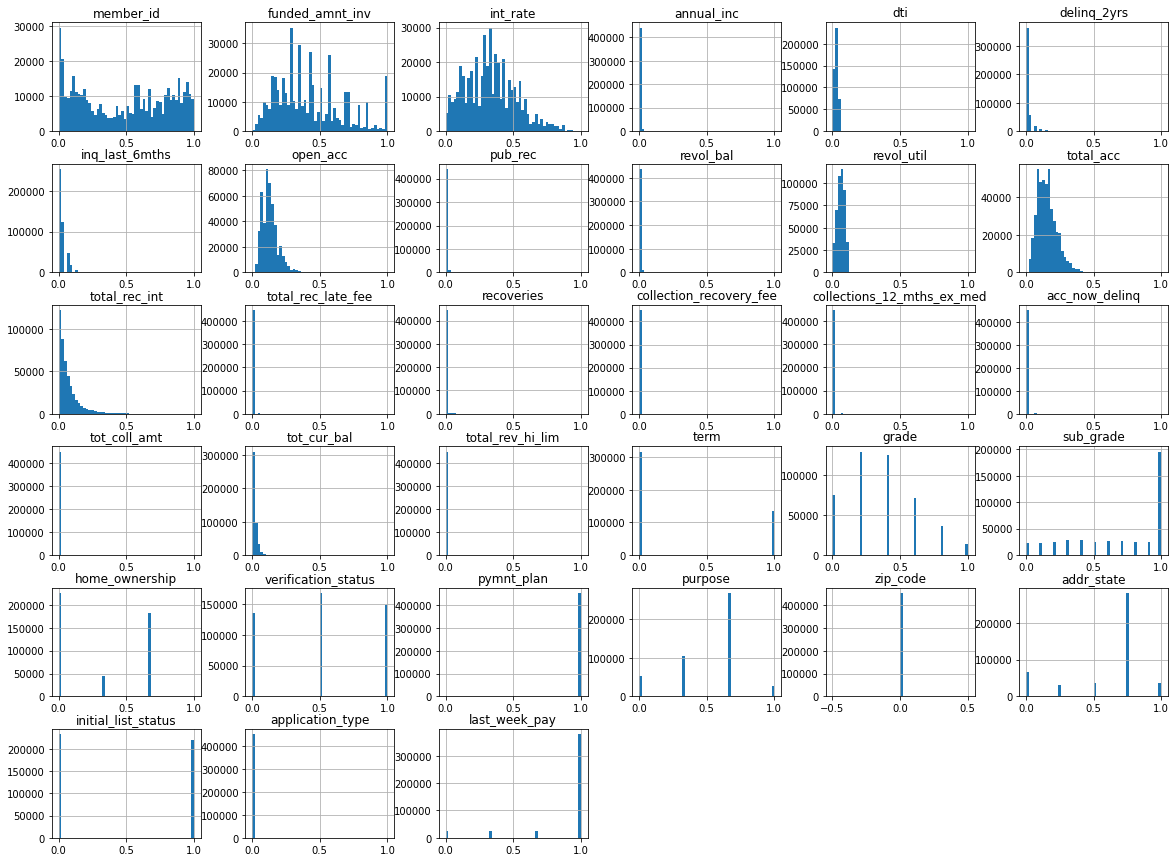

In [452]:
%matplotlib inline
import matplotlib.pyplot as plt
X_train.hist(bins=50, figsize=(20,15))
plt.show()

In [456]:
def model_training_tracking(params):

      auc_list = []
      
      lgb_clf = LGBMClassifier(**params)
      lgb_clf.fit(X_train, y_train, 
                    eval_set = [(X_train, y_train), (X_valid, y_valid)], 
                    early_stopping_rounds=100,
                    verbose=20)

        # Perform model evaluation 
      lgb_valid_prediction = lgb_clf.predict_proba(X_valid)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_valid, lgb_valid_prediction)
      roc_auc = auc(fpr, tpr) # compute area under the curve
      print("=====================================")
      print("Validation AUC:{}".format(roc_auc))
      print("=====================================")   

      score_lgb_valid_prediction = lgb_clf.predict(X_valid)
      score = f1_score(y_valid, score_lgb_valid_prediction, average='weighted')# compute f1 score
      score = 100* score
      print("=====================================")
      print("Validation f1 score:{}".format(score))
      print("=====================================")  
      return score

In [462]:
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "random_state": 42,
        "boosting_type": "gbdt",
        "max_depth": 10
    }
    
    score = model_training_tracking(param)
    return score

In [465]:
'''
param = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "random_state": 42,
        "boosting_type": "gbdt",
        "max_depth": 10
    }

score = model_training_tracking(param)

print(score)'''

'\nparam = {\n        "objective": "binary",\n        "metric": "auc",\n        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),\n        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),\n        "subsample": trial.suggest_float("subsample", 0.4, 1.0),\n        "random_state": 42,\n        "boosting_type": "gbdt",\n        "max_depth": 10\n    }\n\nscore = model_training_tracking(param)\n\nprint(score)'

In [466]:
# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
trial = study.best_trial
print('score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-03-29 19:53:51,332] A new study created in memory with name: no-name-904de5f1-6eea-45a5-bd1d-e2a22ccbdd17


Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.91838	valid_1's auc: 0.919168
[40]	training's auc: 0.930637	valid_1's auc: 0.93059
[60]	training's auc: 0.938199	valid_1's auc: 0.93768
[80]	training's auc: 0.943154	valid_1's auc: 0.942096
[100]	training's auc: 0.946415	valid_1's auc: 0.944986
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.946415	valid_1's auc: 0.944986
Validation AUC:0.9449863146024708


[I 2021-03-29 19:54:10,421] Trial 0 finished with value: 89.79533613288304 and parameters: {'learning_rate': 0.07994406072306989, 'colsample_bytree': 0.9524041781268549, 'subsample': 0.9590897685310017}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:89.79533613288304
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.872416	valid_1's auc: 0.872413
[40]	training's auc: 0.879326	valid_1's auc: 0.87945
[60]	training's auc: 0.874544	valid_1's auc: 0.874796
[80]	training's auc: 0.871913	valid_1's auc: 0.872173
[100]	training's auc: 0.874096	valid_1's auc: 0.874353
Did not meet early stopping. Best iteration is:
[25]	training's auc: 0.88184	valid_1's auc: 0.881932
Validation AUC:0.881931837062554


[I 2021-03-29 19:54:24,141] Trial 1 finished with value: 66.19761736050357 and parameters: {'learning_rate': 0.01088196789691872, 'colsample_bytree': 0.2541537826532476, 'subsample': 0.9156737636276103}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:66.19761736050357
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.893811	valid_1's auc: 0.894567
[40]	training's auc: 0.895035	valid_1's auc: 0.895704
[60]	training's auc: 0.89584	valid_1's auc: 0.896606
[80]	training's auc: 0.896781	valid_1's auc: 0.897736
[100]	training's auc: 0.89803	valid_1's auc: 0.899098
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.89803	valid_1's auc: 0.899098
Validation AUC:0.8990977049031654


[I 2021-03-29 19:54:41,088] Trial 2 finished with value: 66.19761736050357 and parameters: {'learning_rate': 0.0012525987507448085, 'colsample_bytree': 0.8842490875915245, 'subsample': 0.9420620385469904}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:66.19761736050357
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.883693	valid_1's auc: 0.8838
[40]	training's auc: 0.886994	valid_1's auc: 0.887303
[60]	training's auc: 0.886611	valid_1's auc: 0.886968
[80]	training's auc: 0.888921	valid_1's auc: 0.889372
[100]	training's auc: 0.888981	valid_1's auc: 0.889382
Did not meet early stopping. Best iteration is:
[77]	training's auc: 0.88936	valid_1's auc: 0.889765
Validation AUC:0.8897652794944417


[I 2021-03-29 19:54:56,755] Trial 3 finished with value: 77.03292571854173 and parameters: {'learning_rate': 0.009311875478386442, 'colsample_bytree': 0.4222508005884342, 'subsample': 0.8806072112050113}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:77.03292571854173
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.878022	valid_1's auc: 0.878532
[40]	training's auc: 0.882434	valid_1's auc: 0.882846
[60]	training's auc: 0.882841	valid_1's auc: 0.882983
[80]	training's auc: 0.890596	valid_1's auc: 0.890569
[100]	training's auc: 0.891449	valid_1's auc: 0.891393
Did not meet early stopping. Best iteration is:
[92]	training's auc: 0.891691	valid_1's auc: 0.89168
Validation AUC:0.8916803702272811


[I 2021-03-29 19:55:12,418] Trial 4 finished with value: 81.45330984448105 and parameters: {'learning_rate': 0.02616914324543893, 'colsample_bytree': 0.3753791890001744, 'subsample': 0.8718036572316863}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:81.45330984448105
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.899333	valid_1's auc: 0.900308
[40]	training's auc: 0.910605	valid_1's auc: 0.911105
[60]	training's auc: 0.919699	valid_1's auc: 0.919775
[80]	training's auc: 0.927582	valid_1's auc: 0.927509
[100]	training's auc: 0.931142	valid_1's auc: 0.930738
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.931142	valid_1's auc: 0.930738
Validation AUC:0.9307378705673431


[I 2021-03-29 19:55:29,107] Trial 5 finished with value: 87.61383748820796 and parameters: {'learning_rate': 0.07168145962371171, 'colsample_bytree': 0.4993974490654606, 'subsample': 0.5820374599129949}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:87.61383748820796
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.897377	valid_1's auc: 0.898526
[40]	training's auc: 0.902905	valid_1's auc: 0.90437
[60]	training's auc: 0.905075	valid_1's auc: 0.906385
[80]	training's auc: 0.90739	valid_1's auc: 0.908444
[100]	training's auc: 0.909137	valid_1's auc: 0.910127
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.909137	valid_1's auc: 0.910127
Validation AUC:0.9101272253132697


[I 2021-03-29 19:55:46,824] Trial 6 finished with value: 82.91848464967748 and parameters: {'learning_rate': 0.007284769579501747, 'colsample_bytree': 0.9150331209015439, 'subsample': 0.5859462873301333}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:82.91848464967748
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.886628	valid_1's auc: 0.88703
[40]	training's auc: 0.890731	valid_1's auc: 0.891238
[60]	training's auc: 0.891814	valid_1's auc: 0.892195
[80]	training's auc: 0.897398	valid_1's auc: 0.897671
[100]	training's auc: 0.89817	valid_1's auc: 0.898458
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.89817	valid_1's auc: 0.898458
Validation AUC:0.8984578880467724


[I 2021-03-29 19:56:03,194] Trial 7 finished with value: 81.09645731403697 and parameters: {'learning_rate': 0.013851202401347185, 'colsample_bytree': 0.5131591277089267, 'subsample': 0.9184097913983646}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:81.09645731403697
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.8658	valid_1's auc: 0.866302
[40]	training's auc: 0.880747	valid_1's auc: 0.88091
[60]	training's auc: 0.888393	valid_1's auc: 0.888261
[80]	training's auc: 0.900754	valid_1's auc: 0.900246
[100]	training's auc: 0.905903	valid_1's auc: 0.90533
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.905903	valid_1's auc: 0.90533
Validation AUC:0.905330224912683


[I 2021-03-29 19:56:18,687] Trial 8 finished with value: 84.04551578548887 and parameters: {'learning_rate': 0.06221316962041118, 'colsample_bytree': 0.3504346395033384, 'subsample': 0.9357341333707604}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:84.04551578548887
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.893292	valid_1's auc: 0.894147
[40]	training's auc: 0.895863	valid_1's auc: 0.896557
[60]	training's auc: 0.896557	valid_1's auc: 0.897253
[80]	training's auc: 0.897469	valid_1's auc: 0.898218
[100]	training's auc: 0.898711	valid_1's auc: 0.899624
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.898711	valid_1's auc: 0.899624
Validation AUC:0.8996238789544642


[I 2021-03-29 19:56:35,637] Trial 9 finished with value: 66.19761736050357 and parameters: {'learning_rate': 0.0016023624764710093, 'colsample_bytree': 0.7443891769051689, 'subsample': 0.6858003398000216}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:66.19761736050357
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.893523	valid_1's auc: 0.894377
[40]	training's auc: 0.895994	valid_1's auc: 0.896829
[60]	training's auc: 0.897459	valid_1's auc: 0.898433
[80]	training's auc: 0.899253	valid_1's auc: 0.900424
[100]	training's auc: 0.899686	valid_1's auc: 0.900931
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.899686	valid_1's auc: 0.900931
Validation AUC:0.9009307311985911


[I 2021-03-29 19:56:52,479] Trial 10 finished with value: 66.19761736050357 and parameters: {'learning_rate': 0.0028187052781096116, 'colsample_bytree': 0.715226974732538, 'subsample': 0.43702916183893015}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:66.19761736050357
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.905852	valid_1's auc: 0.906655
[40]	training's auc: 0.922384	valid_1's auc: 0.922557
[60]	training's auc: 0.932164	valid_1's auc: 0.931799
[80]	training's auc: 0.936801	valid_1's auc: 0.936111
[100]	training's auc: 0.940211	valid_1's auc: 0.93927
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.940211	valid_1's auc: 0.93927
Validation AUC:0.9392696714449952


[I 2021-03-29 19:57:09,385] Trial 11 finished with value: 88.90664160285141 and parameters: {'learning_rate': 0.09264192945222988, 'colsample_bytree': 0.580818954439253, 'subsample': 0.5132267528752048}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:88.90664160285141
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.908812	valid_1's auc: 0.909796
[40]	training's auc: 0.923765	valid_1's auc: 0.924316
[60]	training's auc: 0.933532	valid_1's auc: 0.933481
[80]	training's auc: 0.938374	valid_1's auc: 0.937993
[100]	training's auc: 0.941611	valid_1's auc: 0.940908
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.941611	valid_1's auc: 0.940908
Validation AUC:0.9409080839365156


[I 2021-03-29 19:57:26,820] Trial 12 finished with value: 89.12003538880406 and parameters: {'learning_rate': 0.08779771677736656, 'colsample_bytree': 0.6532902649019297, 'subsample': 0.44143964801087876}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:89.12003538880406
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.901229	valid_1's auc: 0.902149
[40]	training's auc: 0.913191	valid_1's auc: 0.914052
[60]	training's auc: 0.919312	valid_1's auc: 0.92009
[80]	training's auc: 0.924573	valid_1's auc: 0.925187
[100]	training's auc: 0.928463	valid_1's auc: 0.928861
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.928463	valid_1's auc: 0.928861
Validation AUC:0.9288610280036881


[I 2021-03-29 19:57:44,810] Trial 13 finished with value: 87.70391205260935 and parameters: {'learning_rate': 0.03734624289080707, 'colsample_bytree': 0.765796984871348, 'subsample': 0.7689828513191233}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:87.70391205260935
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.908646	valid_1's auc: 0.909608
[40]	training's auc: 0.916066	valid_1's auc: 0.91683
[60]	training's auc: 0.922846	valid_1's auc: 0.923305
[80]	training's auc: 0.929614	valid_1's auc: 0.929723
[100]	training's auc: 0.933582	valid_1's auc: 0.933392
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.933582	valid_1's auc: 0.933392
Validation AUC:0.9333918887537898


[I 2021-03-29 19:58:03,687] Trial 14 finished with value: 88.4936731951025 and parameters: {'learning_rate': 0.03751505495018688, 'colsample_bytree': 0.984428934933784, 'subsample': 0.4140087244311339}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:88.4936731951025
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.900227	valid_1's auc: 0.901644
[40]	training's auc: 0.907626	valid_1's auc: 0.908624
[60]	training's auc: 0.913071	valid_1's auc: 0.914037
[80]	training's auc: 0.916887	valid_1's auc: 0.917699
[100]	training's auc: 0.920488	valid_1's auc: 0.921234
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.920488	valid_1's auc: 0.921234
Validation AUC:0.92123383662442


[I 2021-03-29 19:58:21,662] Trial 15 finished with value: 86.59858235442915 and parameters: {'learning_rate': 0.02171737299444571, 'colsample_bytree': 0.8348188976700319, 'subsample': 0.7671265641827565}. Best is trial 0 with value: 89.79533613288304.


Validation f1 score:86.59858235442915
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.921038	valid_1's auc: 0.921931
[40]	training's auc: 0.934632	valid_1's auc: 0.93454
[60]	training's auc: 0.941639	valid_1's auc: 0.940808
[80]	training's auc: 0.946241	valid_1's auc: 0.944994
[100]	training's auc: 0.949606	valid_1's auc: 0.948121
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.949606	valid_1's auc: 0.948121
Validation AUC:0.9481212722333692


[I 2021-03-29 19:58:40,745] Trial 16 finished with value: 90.12840905713063 and parameters: {'learning_rate': 0.09723540598877604, 'colsample_bytree': 0.9713803348966582, 'subsample': 0.6670345825662228}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:90.12840905713063
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.909815	valid_1's auc: 0.910787
[40]	training's auc: 0.918446	valid_1's auc: 0.919195
[60]	training's auc: 0.925843	valid_1's auc: 0.926242
[80]	training's auc: 0.932118	valid_1's auc: 0.931972
[100]	training's auc: 0.93601	valid_1's auc: 0.935689
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.93601	valid_1's auc: 0.935689
Validation AUC:0.9356885043109613


[I 2021-03-29 19:58:59,644] Trial 17 finished with value: 88.69506045245824 and parameters: {'learning_rate': 0.04414866651140775, 'colsample_bytree': 0.9859544513988141, 'subsample': 0.6883325725466927}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:88.69506045245824
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.896343	valid_1's auc: 0.897174
[40]	training's auc: 0.901572	valid_1's auc: 0.902952
[60]	training's auc: 0.903379	valid_1's auc: 0.90484
[80]	training's auc: 0.904734	valid_1's auc: 0.906128
[100]	training's auc: 0.90628	valid_1's auc: 0.907495
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.90628	valid_1's auc: 0.907495
Validation AUC:0.9074945444024783


[I 2021-03-29 19:59:17,153] Trial 18 finished with value: 76.59393299465341 and parameters: {'learning_rate': 0.004738242266697285, 'colsample_bytree': 0.9981506289889243, 'subsample': 0.7889109317327295}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:76.59393299465341
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.914677	valid_1's auc: 0.915976
[40]	training's auc: 0.931915	valid_1's auc: 0.932206
[60]	training's auc: 0.939769	valid_1's auc: 0.939403
[80]	training's auc: 0.944521	valid_1's auc: 0.943766
[100]	training's auc: 0.947914	valid_1's auc: 0.946755
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.947914	valid_1's auc: 0.946755
Validation AUC:0.9467547836564482


[I 2021-03-29 19:59:35,375] Trial 19 finished with value: 90.04304104554737 and parameters: {'learning_rate': 0.09915420827997998, 'colsample_bytree': 0.8351166795182489, 'subsample': 0.6130426361549333}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:90.04304104554737
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.900049	valid_1's auc: 0.901496
[40]	training's auc: 0.906922	valid_1's auc: 0.907912
[60]	training's auc: 0.912219	valid_1's auc: 0.913118
[80]	training's auc: 0.916253	valid_1's auc: 0.917137
[100]	training's auc: 0.9197	valid_1's auc: 0.920464
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.9197	valid_1's auc: 0.920464
Validation AUC:0.9204636996320643


[I 2021-03-29 19:59:53,276] Trial 20 finished with value: 86.428658356434 and parameters: {'learning_rate': 0.02046489807179321, 'colsample_bytree': 0.829422060400193, 'subsample': 0.5992733827863861}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:86.428658356434
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.914425	valid_1's auc: 0.91525
[40]	training's auc: 0.924001	valid_1's auc: 0.92465
[60]	training's auc: 0.932582	valid_1's auc: 0.932451
[80]	training's auc: 0.937851	valid_1's auc: 0.93731
[100]	training's auc: 0.941936	valid_1's auc: 0.941054
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.941936	valid_1's auc: 0.941054
Validation AUC:0.9410543794105437


[I 2021-03-29 20:00:12,083] Trial 21 finished with value: 89.29968705991288 and parameters: {'learning_rate': 0.06084405797872411, 'colsample_bytree': 0.9235010439801887, 'subsample': 0.640806073271013}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:89.29968705991288
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.913912	valid_1's auc: 0.914727
[40]	training's auc: 0.928254	valid_1's auc: 0.928481
[60]	training's auc: 0.937516	valid_1's auc: 0.937106
[80]	training's auc: 0.942553	valid_1's auc: 0.941788
[100]	training's auc: 0.946259	valid_1's auc: 0.945028
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.946259	valid_1's auc: 0.945028
Validation AUC:0.9450283819778507


[I 2021-03-29 20:00:30,191] Trial 22 finished with value: 89.8420563915636 and parameters: {'learning_rate': 0.08899392126272124, 'colsample_bytree': 0.8345245414633632, 'subsample': 0.5051423622961102}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:89.8420563915636
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.906102	valid_1's auc: 0.90726
[40]	training's auc: 0.918111	valid_1's auc: 0.918976
[60]	training's auc: 0.925906	valid_1's auc: 0.926586
[80]	training's auc: 0.931848	valid_1's auc: 0.932098
[100]	training's auc: 0.936023	valid_1's auc: 0.936045
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.936023	valid_1's auc: 0.936045
Validation AUC:0.9360445699353571


[I 2021-03-29 20:00:48,449] Trial 23 finished with value: 88.68389718542386 and parameters: {'learning_rate': 0.04958351799468652, 'colsample_bytree': 0.8337713596606853, 'subsample': 0.5210877729812776}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:88.68389718542386
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.913275	valid_1's auc: 0.914218
[40]	training's auc: 0.926508	valid_1's auc: 0.926977
[60]	training's auc: 0.935293	valid_1's auc: 0.935265
[80]	training's auc: 0.93968	valid_1's auc: 0.939282
[100]	training's auc: 0.942995	valid_1's auc: 0.942239
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.942995	valid_1's auc: 0.942239
Validation AUC:0.9422391344901611


[I 2021-03-29 20:01:06,120] Trial 24 finished with value: 89.33306098079645 and parameters: {'learning_rate': 0.08810382861759629, 'colsample_bytree': 0.6950189445138726, 'subsample': 0.5064410057578795}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:89.33306098079645
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.914259	valid_1's auc: 0.915247
[40]	training's auc: 0.930651	valid_1's auc: 0.93091
[60]	training's auc: 0.938124	valid_1's auc: 0.93778
[80]	training's auc: 0.943119	valid_1's auc: 0.942427
[100]	training's auc: 0.946566	valid_1's auc: 0.945526
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.946566	valid_1's auc: 0.945526
Validation AUC:0.945525777368823


[I 2021-03-29 20:01:24,201] Trial 25 finished with value: 89.84878612964242 and parameters: {'learning_rate': 0.09467734028632259, 'colsample_bytree': 0.8013980294740587, 'subsample': 0.639921618384813}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:89.84878612964242
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.900931	valid_1's auc: 0.9021
[40]	training's auc: 0.911094	valid_1's auc: 0.911946
[60]	training's auc: 0.916383	valid_1's auc: 0.91714
[80]	training's auc: 0.922275	valid_1's auc: 0.922947
[100]	training's auc: 0.926707	valid_1's auc: 0.927166
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.926707	valid_1's auc: 0.927166
Validation AUC:0.9271659124132401


[I 2021-03-29 20:01:42,170] Trial 26 finished with value: 87.40835534614033 and parameters: {'learning_rate': 0.032443550496429566, 'colsample_bytree': 0.7763766317495722, 'subsample': 0.6311875383847116}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:87.40835534614033
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.901557	valid_1's auc: 0.902827
[40]	training's auc: 0.913493	valid_1's auc: 0.914633
[60]	training's auc: 0.921584	valid_1's auc: 0.92244
[80]	training's auc: 0.927219	valid_1's auc: 0.927671
[100]	training's auc: 0.931233	valid_1's auc: 0.931419
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.931233	valid_1's auc: 0.931419
Validation AUC:0.9314191223966779


[I 2021-03-29 20:01:59,694] Trial 27 finished with value: 87.7360492676593 and parameters: {'learning_rate': 0.05288436318071293, 'colsample_bytree': 0.6311355479989563, 'subsample': 0.7304888644838339}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:87.7360492676593
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.899278	valid_1's auc: 0.900798
[40]	training's auc: 0.905783	valid_1's auc: 0.906744
[60]	training's auc: 0.910361	valid_1's auc: 0.911307
[80]	training's auc: 0.913626	valid_1's auc: 0.914563
[100]	training's auc: 0.916392	valid_1's auc: 0.917292
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.916392	valid_1's auc: 0.917292
Validation AUC:0.9172920643995218


[I 2021-03-29 20:02:17,726] Trial 28 finished with value: 85.62951817390183 and parameters: {'learning_rate': 0.01589050798485814, 'colsample_bytree': 0.8628455585351692, 'subsample': 0.6581921574114893}. Best is trial 16 with value: 90.12840905713063.


Validation f1 score:85.62951817390183
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.921522	valid_1's auc: 0.922463
[40]	training's auc: 0.934968	valid_1's auc: 0.934869
[60]	training's auc: 0.942416	valid_1's auc: 0.941737
[80]	training's auc: 0.946796	valid_1's auc: 0.945605
[100]	training's auc: 0.949887	valid_1's auc: 0.948309
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.949887	valid_1's auc: 0.948309
Validation AUC:0.9483087756417746


[I 2021-03-29 20:02:36,240] Trial 29 finished with value: 90.20350578111501 and parameters: {'learning_rate': 0.0997893957223435, 'colsample_bytree': 0.9456983643328636, 'subsample': 0.5566654747428619}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:90.20350578111501
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.916062	valid_1's auc: 0.917137
[40]	training's auc: 0.928052	valid_1's auc: 0.928433
[60]	training's auc: 0.935666	valid_1's auc: 0.935514
[80]	training's auc: 0.940706	valid_1's auc: 0.939997
[100]	training's auc: 0.944447	valid_1's auc: 0.943361
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.944447	valid_1's auc: 0.943361
Validation AUC:0.943360909419967


[I 2021-03-29 20:02:55,146] Trial 30 finished with value: 89.55262976714641 and parameters: {'learning_rate': 0.06936255920213508, 'colsample_bytree': 0.9557644122440245, 'subsample': 0.5836263327045317}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:89.55262976714641
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.919916	valid_1's auc: 0.920807
[40]	training's auc: 0.93285	valid_1's auc: 0.932917
[60]	training's auc: 0.940402	valid_1's auc: 0.939736
[80]	training's auc: 0.945281	valid_1's auc: 0.944006
[100]	training's auc: 0.948522	valid_1's auc: 0.947004
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.948522	valid_1's auc: 0.947004
Validation AUC:0.9470035004892847


[I 2021-03-29 20:03:13,805] Trial 31 finished with value: 89.9954057706443 and parameters: {'learning_rate': 0.09321459672362115, 'colsample_bytree': 0.9095060711408162, 'subsample': 0.5489778516476037}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:89.9954057706443
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.919788	valid_1's auc: 0.920622
[40]	training's auc: 0.933024	valid_1's auc: 0.932879
[60]	training's auc: 0.940601	valid_1's auc: 0.9398
[80]	training's auc: 0.945286	valid_1's auc: 0.944041
[100]	training's auc: 0.948742	valid_1's auc: 0.947092
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.948742	valid_1's auc: 0.947092
Validation AUC:0.9470917097558895


[I 2021-03-29 20:03:32,083] Trial 32 finished with value: 90.049555731259 and parameters: {'learning_rate': 0.09645058231310236, 'colsample_bytree': 0.930462498405691, 'subsample': 0.7272318041334357}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:90.049555731259
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.921517	valid_1's auc: 0.922457
[40]	training's auc: 0.93514	valid_1's auc: 0.935045
[60]	training's auc: 0.941943	valid_1's auc: 0.941199
[80]	training's auc: 0.946438	valid_1's auc: 0.945147
[100]	training's auc: 0.949687	valid_1's auc: 0.948
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.949687	valid_1's auc: 0.948
Validation AUC:0.9480003746327686


[I 2021-03-29 20:03:51,120] Trial 33 finished with value: 90.12214133510375 and parameters: {'learning_rate': 0.09969327390101837, 'colsample_bytree': 0.951529157117464, 'subsample': 0.8184816757206514}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:90.12214133510375
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.915252	valid_1's auc: 0.916085
[40]	training's auc: 0.926072	valid_1's auc: 0.926352
[60]	training's auc: 0.934614	valid_1's auc: 0.934419
[80]	training's auc: 0.940019	valid_1's auc: 0.939359
[100]	training's auc: 0.943667	valid_1's auc: 0.942596
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.943667	valid_1's auc: 0.942596
Validation AUC:0.9425957203025319


[I 2021-03-29 20:04:10,198] Trial 34 finished with value: 89.49277421784691 and parameters: {'learning_rate': 0.06596978273225589, 'colsample_bytree': 0.9487644838874826, 'subsample': 0.80849480730066}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:89.49277421784691
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.873242	valid_1's auc: 0.872991
[40]	training's auc: 0.885549	valid_1's auc: 0.885351
[60]	training's auc: 0.886886	valid_1's auc: 0.886792
[80]	training's auc: 0.888968	valid_1's auc: 0.88882
[100]	training's auc: 0.892692	valid_1's auc: 0.892349
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.892692	valid_1's auc: 0.892349
Validation AUC:0.8923489966247247


[I 2021-03-29 20:04:24,786] Trial 35 finished with value: 82.40756891012059 and parameters: {'learning_rate': 0.04693956681975413, 'colsample_bytree': 0.21034807464334648, 'subsample': 0.8322673247282977}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:82.40756891012059
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.906323	valid_1's auc: 0.907372
[40]	training's auc: 0.912757	valid_1's auc: 0.913585
[60]	training's auc: 0.91781	valid_1's auc: 0.918498
[80]	training's auc: 0.922985	valid_1's auc: 0.923705
[100]	training's auc: 0.928179	valid_1's auc: 0.928553
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.928179	valid_1's auc: 0.928553
Validation AUC:0.9285531832826588


[I 2021-03-29 20:04:43,762] Trial 36 finished with value: 88.02038873888269 and parameters: {'learning_rate': 0.02854946534721455, 'colsample_bytree': 0.9982648890981084, 'subsample': 0.9866243431987104}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:88.02038873888269
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.913441	valid_1's auc: 0.91426
[40]	training's auc: 0.926913	valid_1's auc: 0.92735
[60]	training's auc: 0.934907	valid_1's auc: 0.934697
[80]	training's auc: 0.940656	valid_1's auc: 0.940034
[100]	training's auc: 0.944221	valid_1's auc: 0.943269
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.944221	valid_1's auc: 0.943269
Validation AUC:0.9432688109218625


[I 2021-03-29 20:05:01,349] Trial 37 finished with value: 89.5507597500363 and parameters: {'learning_rate': 0.07338499551393339, 'colsample_bytree': 0.8893002091986225, 'subsample': 0.7270605110479611}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:89.5507597500363
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.921535	valid_1's auc: 0.922513
[40]	training's auc: 0.934697	valid_1's auc: 0.934579
[60]	training's auc: 0.942015	valid_1's auc: 0.941144
[80]	training's auc: 0.946513	valid_1's auc: 0.945155
[100]	training's auc: 0.949722	valid_1's auc: 0.948114
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.949722	valid_1's auc: 0.948114
Validation AUC:0.9481137486450799


[I 2021-03-29 20:05:18,792] Trial 38 finished with value: 90.16841643535857 and parameters: {'learning_rate': 0.09935427870039079, 'colsample_bytree': 0.9478077526380191, 'subsample': 0.8659406429295167}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:90.16841643535857
Training until validation scores don't improve for 100 rounds.
[20]	training's auc: 0.909503	valid_1's auc: 0.910606
[40]	training's auc: 0.920442	valid_1's auc: 0.921383
[60]	training's auc: 0.929147	valid_1's auc: 0.929552
[80]	training's auc: 0.934379	valid_1's auc: 0.934352
[100]	training's auc: 0.938663	valid_1's auc: 0.938359
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.938663	valid_1's auc: 0.938359
Validation AUC:0.9383588462222361


[I 2021-03-29 20:05:35,846] Trial 39 finished with value: 88.94681040270004 and parameters: {'learning_rate': 0.052559445160101845, 'colsample_bytree': 0.8793970085861711, 'subsample': 0.8766093639230343}. Best is trial 29 with value: 90.20350578111501.


Validation f1 score:88.94681040270004
score: 90.20350578111501
Best hyperparameters: {'learning_rate': 0.0997893957223435, 'colsample_bytree': 0.9456983643328636, 'subsample': 0.5566654747428619}


## Load best lightgbm model

Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.731397	valid_1's auc: 0.727566
[40]	training's auc: 0.747498	valid_1's auc: 0.73722
[60]	training's auc: 0.759597	valid_1's auc: 0.74465
[80]	training's auc: 0.768097	valid_1's auc: 0.748425
[100]	training's auc: 0.775216	valid_1's auc: 0.75117
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.775216	valid_1's auc: 0.75117
Validation AUC:0.7511701152646802
Validation f1 score:70.74448087542362


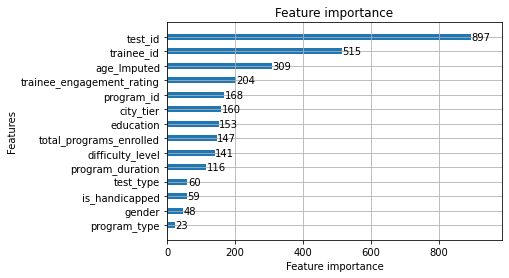

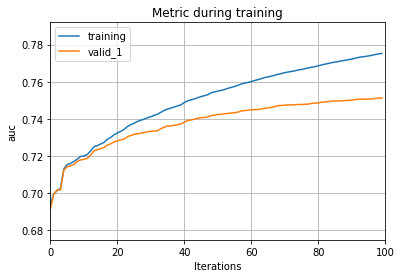

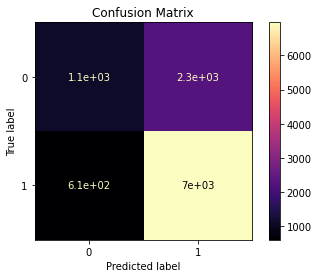

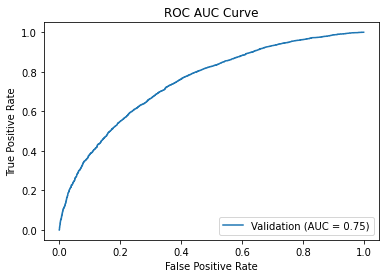

In [ ]:
    # Define model parameter
params = {
    "objective": "binary",
    "learning_rate": 0.09572800106895159,
    "metric": "auc",
    "colsample_bytree": 0.7644061582678274,
    "subsample": 0.9535102305256186,
    "boosting_type": "gbdt",
    "seed": 42,
    "max_depth": 10
}

# Perform model training
lgb_clf = LGBMClassifier(**params)
lgb_clf.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_valid, y_valid)], 
        early_stopping_rounds=50,
        verbose=20)

# Log model artifacts
#   mlflow.sklearn.log_model(lgb_clf, "model")

# Perform model evaluation 
lgb_valid_prediction = lgb_clf.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, lgb_valid_prediction)
roc_auc = auc(fpr, tpr) # compute area under the curve
print("=====================================")
print("Validation AUC:{}".format(roc_auc))
print("=====================================")   

score_lgb_valid_prediction = lgb_clf.predict(X_valid)
score = f1_score(y_valid, score_lgb_valid_prediction, average='weighted')# compute f1 score
score = 100* score
print("=====================================")
print("Validation f1 score:{}".format(score))
print("=====================================") 


# Plot and save feature importance details
ax = plot_importance(lgb_clf, height=0.4)
filename = '/content/images/lgb_validation_feature_importance.png'
plt.savefig(filename)


ax = plot_metric(lgb_clf.evals_result_)
filename = '/content/images/lgb_validation_metrics_comparision.png'
plt.savefig(filename)


# Plot and save metrics details    
plot_confusion_matrix(lgb_clf, X_valid, y_valid, 
                  display_labels=['0', '1'],
                  cmap='magma')
plt.title('Confusion Matrix')
filename = '/content/images/lgb_validation_confusion_matrix.png'
plt.savefig(filename)


# Plot and save AUC details  
plot_roc_curve(lgb_clf, X_valid, y_valid, name='Validation')
plt.title('ROC AUC Curve')
filename = '/content/images/lgb_validation_roc_curve.png'
plt.savefig(filename)


In [ ]:
# Remove column name 'id'and age 
test_data = test_data.drop(['id','age'], axis = 1)

In [ ]:
test_data.head()

,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,total_programs_enrolled,is_handicapped,trainee_engagement_rating,age_Imputed
0,0.095238,0.166667,0.736842,0.240642,0.0,0.666667,0.080858,0.0,0.75,0.666667,0.076923,0.0,0.8,0.630435
1,0.809524,0.833333,0.947368,0.695187,1.0,0.000000,0.548291,1.0,0.00,0.666667,0.230769,0.0,0.8,0.422628
2,0.761905,0.833333,0.157895,0.780749,1.0,0.000000,0.629497,1.0,0.75,0.666667,0.076923,0.0,0.6,0.422628
3,0.523810,0.500000,0.263158,0.385027,0.0,1.000000,0.350152,0.0,0.25,0.000000,0.076923,0.0,0.4,0.422628
4,0.523810,0.500000,0.263158,0.379679,0.0,0.666667,0.044136,0.0,0.75,0.666667,0.076923,0.0,0.4,0.422628


In [ ]:
# Make prediction aganist Validation data
lgb_best_val_prediction = lgb_clf.predict(test_data)
#print(lgb_best_val_prediction)
# dictionary of lists  
dict = {'id': ID, 'is_pass': lgb_best_val_prediction}  
    
df = pd.DataFrame(dict) 
df.is_pass.value_counts()

1    20606
0    10743
Name: is_pass, dtype: int64

In [ ]:
df

,id,is_pass
0,1626_45,1
1,11020_130,1
2,12652_146,0
3,7038_72,1
4,888_71,1
...,...,...
31344,18820_22,1
31345,1641_96,0
31346,7010_157,0
31347,14895_179,0


In [ ]:
df.to_csv('/content/my_submission.csv', index=False) 